<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/Semi_Superviesd_Learning_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semi-supervised GAN for improviong Discriminator**

* code reference Link :   https://github.com/nejlag/Semi-Supervised-Learning-GAN/blob/master/SSL_GAN.ipynb 

텐서플로우 코드를 파이토치로 구현하는 연습

In [1]:
import numpy as np
import time
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
# Hyper-parameters
batch_size = 100
num_epochs = 200
num_classes = 10
latent_dim = 100
img_size = 28
learning_rate = 0.00002

In [52]:
train_transforms =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
                                      
train_dataset = torchvision.datasets.MNIST(root = "./data", train = True, download = True,
                                           transform = train_transforms)
dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100, shuffle = True, num_workers = 4 )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Do not use Batch Normalization on the first layer of Discriminator
    self.model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 5, stride = 2, padding = 2),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.5),
        nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.5),
        nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.2, inplace = True),        
    )
    self.fc_real = nn.Linear(512, 1)
    self.fc_class = nn.Linear(512, num_classes)
  def forward(self, imgs):
    conv_features = self.model(imgs)
    flatten = conv_features.view(imgs.size(0), -1)
    outputs_real = torch.sigmoid(self.fc_real(flatten))
    outputs_class = self.fc_class(flatten)

    return outputs_real, outputs_class

In [33]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.class_emb = nn.Embedding(num_classes, latent_dim)
    self.init_size = img_size // 4    # Initial size before upsampling
    self.fc = nn.Linear(latent_dim, 128 * self.init_size ** 2)

    self.model = nn.Sequential(
        nn.BatchNorm2d(128),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(128, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(64, 1, kernel_size = 3, stride = 1, padding = 1),
        nn.Tanh(),
    )
  def forward(self, z, c):
    conditioned_z = torch.mul(z, self.class_emb(c))
    out = self.fc(conditioned_z)
    out = out.view(out.size(0), 128, self.init_size, self.init_size)
    generated_imgs = self.model(out)
    return generated_imgs

In [39]:
def plot_fake_imgs(imgs, grid_size = [5, 5]):
  # Visualize some data generated by G
  _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                         sharey = True, sharex = True)
  
  size = grid_size[0] * grid_size[1]
  index = np.int_(np.random.uniform(0, imgs.shape[0], size = (size)))
  figs = imgs[index].reshape(-1, img_size, img_size)

  for idx, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(figs[idx], cmap = "gray")
  plt.tight_layout()
  plt.show()

In [34]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [53]:
# Loss and optimizer
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate , betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1 / 200], Generator Loss : 1.7909642457962036, Discriminator Loss : 1.216383457183838
Discriminator's fake image acc : 10.57, Discriminator's real image acc : 42.34
Epoch [2 / 200], Generator Loss : 1.846545696258545, Discriminator Loss : 1.1366534233093262
Discriminator's fake image acc : 11.57, Discriminator's real image acc : 73.08
Epoch [3 / 200], Generator Loss : 1.8124114274978638, Discriminator Loss : 1.0894286632537842
Discriminator's fake image acc : 11.9, Discriminator's real image acc : 80.21
Epoch [4 / 200], Generator Loss : 1.8141297101974487, Discriminator Loss : 1.0168044567108154
Discriminator's fake image acc : 12.01, Discriminator's real image acc : 83.58
Epoch [5 / 200], Generator Loss : 1.9138563871383667, Discriminator Loss : 0.9894702434539795
Discriminator's fake image acc : 12.4, Discriminator's real image acc : 85.04
Epoch [6 / 200], Generator Loss : 2.004179000854492, Discriminator Loss : 1.0334376096725464
Discriminator's fake image acc : 12.8, Discrim

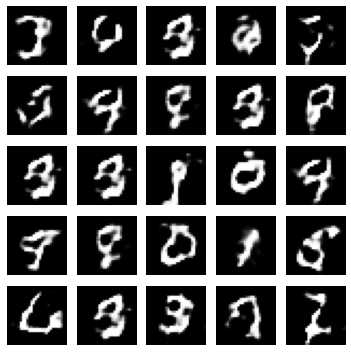

Epoch [10 / 200], Generator Loss : 2.187100648880005, Discriminator Loss : 0.9812861084938049
Discriminator's fake image acc : 12.06, Discriminator's real image acc : 89.95
Epoch [11 / 200], Generator Loss : 1.9802350997924805, Discriminator Loss : 0.9246184825897217
Discriminator's fake image acc : 12.38, Discriminator's real image acc : 90.29
Epoch [12 / 200], Generator Loss : 2.221369981765747, Discriminator Loss : 0.9622556567192078
Discriminator's fake image acc : 12.24, Discriminator's real image acc : 90.56
Epoch [13 / 200], Generator Loss : 2.1474244594573975, Discriminator Loss : 1.0212986469268799
Discriminator's fake image acc : 12.48, Discriminator's real image acc : 90.61
Epoch [14 / 200], Generator Loss : 2.1359643936157227, Discriminator Loss : 0.9912400245666504
Discriminator's fake image acc : 12.74, Discriminator's real image acc : 90.73
Epoch [15 / 200], Generator Loss : 2.1397957801818848, Discriminator Loss : 0.9602802991867065
Discriminator's fake image acc : 12.8

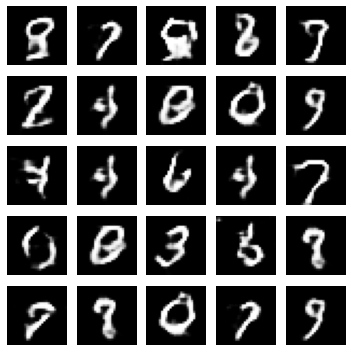

Epoch [20 / 200], Generator Loss : 2.045658826828003, Discriminator Loss : 0.9588654637336731
Discriminator's fake image acc : 14.35, Discriminator's real image acc : 91.57
Epoch [21 / 200], Generator Loss : 2.1093225479125977, Discriminator Loss : 0.9397998452186584
Discriminator's fake image acc : 14.3, Discriminator's real image acc : 91.89
Epoch [22 / 200], Generator Loss : 2.091355800628662, Discriminator Loss : 1.018815040588379
Discriminator's fake image acc : 14.91, Discriminator's real image acc : 91.83
Epoch [23 / 200], Generator Loss : 2.019446611404419, Discriminator Loss : 0.9962700605392456
Discriminator's fake image acc : 14.5, Discriminator's real image acc : 91.96
Epoch [24 / 200], Generator Loss : 2.0632693767547607, Discriminator Loss : 0.9623336791992188
Discriminator's fake image acc : 15.23, Discriminator's real image acc : 92.0
Epoch [25 / 200], Generator Loss : 2.088202953338623, Discriminator Loss : 0.9362841844558716
Discriminator's fake image acc : 15.38, Dis

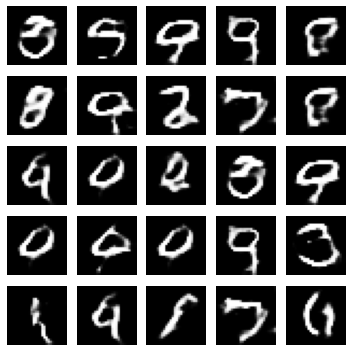

Epoch [30 / 200], Generator Loss : 2.1262707710266113, Discriminator Loss : 0.9495296478271484
Discriminator's fake image acc : 16.09, Discriminator's real image acc : 92.24
Epoch [31 / 200], Generator Loss : 2.1539998054504395, Discriminator Loss : 0.9499642848968506
Discriminator's fake image acc : 16.15, Discriminator's real image acc : 92.22
Epoch [32 / 200], Generator Loss : 2.0531136989593506, Discriminator Loss : 0.9729623794555664
Discriminator's fake image acc : 16.3, Discriminator's real image acc : 92.25
Epoch [33 / 200], Generator Loss : 2.101350784301758, Discriminator Loss : 0.9106524586677551
Discriminator's fake image acc : 16.62, Discriminator's real image acc : 92.39
Epoch [34 / 200], Generator Loss : 2.106114387512207, Discriminator Loss : 0.9239130020141602
Discriminator's fake image acc : 16.36, Discriminator's real image acc : 92.42
Epoch [35 / 200], Generator Loss : 2.092562675476074, Discriminator Loss : 0.9276278018951416
Discriminator's fake image acc : 16.82,

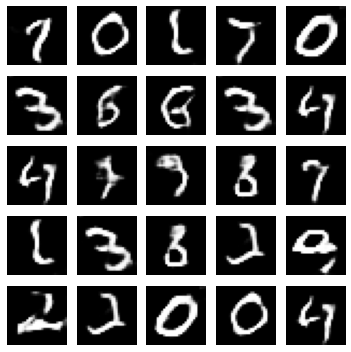

Epoch [40 / 200], Generator Loss : 2.2515363693237305, Discriminator Loss : 0.9490376710891724
Discriminator's fake image acc : 17.49, Discriminator's real image acc : 92.34
Epoch [41 / 200], Generator Loss : 2.1910476684570312, Discriminator Loss : 0.9366798996925354
Discriminator's fake image acc : 17.4, Discriminator's real image acc : 92.3
Epoch [42 / 200], Generator Loss : 2.1941568851470947, Discriminator Loss : 0.9708160758018494
Discriminator's fake image acc : 17.57, Discriminator's real image acc : 92.39
Epoch [43 / 200], Generator Loss : 2.2488389015197754, Discriminator Loss : 0.9109476804733276
Discriminator's fake image acc : 17.29, Discriminator's real image acc : 92.43
Epoch [44 / 200], Generator Loss : 2.1749446392059326, Discriminator Loss : 0.9287592172622681
Discriminator's fake image acc : 17.47, Discriminator's real image acc : 92.38
Epoch [45 / 200], Generator Loss : 2.096712112426758, Discriminator Loss : 0.897106409072876
Discriminator's fake image acc : 17.31,

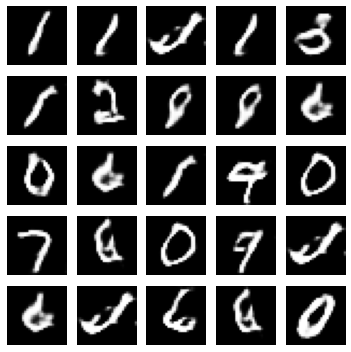

Epoch [50 / 200], Generator Loss : 2.1963858604431152, Discriminator Loss : 0.9304991960525513
Discriminator's fake image acc : 18.62, Discriminator's real image acc : 92.29
Epoch [51 / 200], Generator Loss : 2.3453071117401123, Discriminator Loss : 0.9708703756332397
Discriminator's fake image acc : 18.28, Discriminator's real image acc : 92.41
Epoch [52 / 200], Generator Loss : 2.1658616065979004, Discriminator Loss : 0.9304413795471191
Discriminator's fake image acc : 17.88, Discriminator's real image acc : 92.37
Epoch [53 / 200], Generator Loss : 2.2752761840820312, Discriminator Loss : 0.894329309463501
Discriminator's fake image acc : 18.38, Discriminator's real image acc : 92.26
Epoch [54 / 200], Generator Loss : 2.198178768157959, Discriminator Loss : 0.8528993725776672
Discriminator's fake image acc : 18.55, Discriminator's real image acc : 92.2
Epoch [55 / 200], Generator Loss : 2.1850781440734863, Discriminator Loss : 1.0033857822418213
Discriminator's fake image acc : 18.35

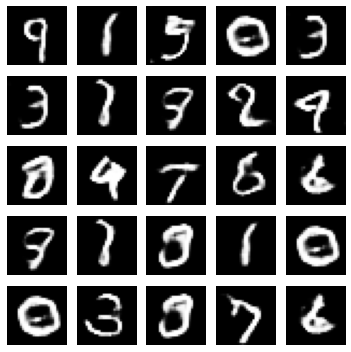

Epoch [60 / 200], Generator Loss : 2.267618179321289, Discriminator Loss : 0.8568123579025269
Discriminator's fake image acc : 18.81, Discriminator's real image acc : 92.33
Epoch [61 / 200], Generator Loss : 2.220569372177124, Discriminator Loss : 0.9319601655006409
Discriminator's fake image acc : 19.05, Discriminator's real image acc : 92.11
Epoch [62 / 200], Generator Loss : 2.2182207107543945, Discriminator Loss : 0.867190957069397
Discriminator's fake image acc : 19.18, Discriminator's real image acc : 92.25
Epoch [63 / 200], Generator Loss : 2.3389463424682617, Discriminator Loss : 0.9261157512664795
Discriminator's fake image acc : 18.95, Discriminator's real image acc : 92.12
Epoch [64 / 200], Generator Loss : 2.1655054092407227, Discriminator Loss : 0.9835927486419678
Discriminator's fake image acc : 19.36, Discriminator's real image acc : 92.23
Epoch [65 / 200], Generator Loss : 2.245035171508789, Discriminator Loss : 0.9010515213012695
Discriminator's fake image acc : 19.04,

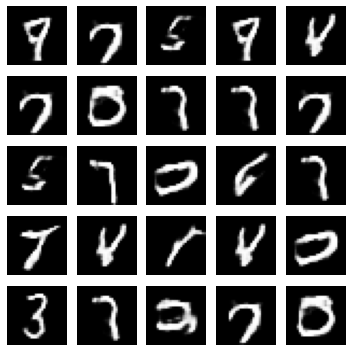

Epoch [70 / 200], Generator Loss : 2.2041878700256348, Discriminator Loss : 0.9061936140060425
Discriminator's fake image acc : 19.21, Discriminator's real image acc : 92.04
Epoch [71 / 200], Generator Loss : 2.2052359580993652, Discriminator Loss : 0.8570849895477295
Discriminator's fake image acc : 19.6, Discriminator's real image acc : 92.3
Epoch [72 / 200], Generator Loss : 2.31674861907959, Discriminator Loss : 0.880359411239624
Discriminator's fake image acc : 19.85, Discriminator's real image acc : 92.12
Epoch [73 / 200], Generator Loss : 2.2207469940185547, Discriminator Loss : 0.8902614116668701
Discriminator's fake image acc : 19.71, Discriminator's real image acc : 91.99
Epoch [74 / 200], Generator Loss : 2.27108097076416, Discriminator Loss : 0.8455474376678467
Discriminator's fake image acc : 20.01, Discriminator's real image acc : 91.98
Epoch [75 / 200], Generator Loss : 2.3653788566589355, Discriminator Loss : 0.9489439129829407
Discriminator's fake image acc : 19.63, Di

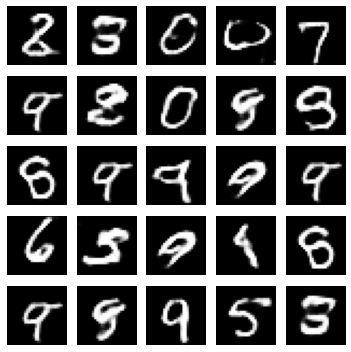

Epoch [80 / 200], Generator Loss : 2.4060630798339844, Discriminator Loss : 0.8804672956466675
Discriminator's fake image acc : 20.12, Discriminator's real image acc : 92.04
Epoch [81 / 200], Generator Loss : 2.255824565887451, Discriminator Loss : 0.9129220843315125
Discriminator's fake image acc : 20.09, Discriminator's real image acc : 92.12
Epoch [82 / 200], Generator Loss : 2.365985155105591, Discriminator Loss : 0.9275917410850525
Discriminator's fake image acc : 20.47, Discriminator's real image acc : 92.12
Epoch [83 / 200], Generator Loss : 2.4053707122802734, Discriminator Loss : 0.9014723300933838
Discriminator's fake image acc : 20.24, Discriminator's real image acc : 92.03
Epoch [84 / 200], Generator Loss : 2.1232588291168213, Discriminator Loss : 0.9331199526786804
Discriminator's fake image acc : 20.01, Discriminator's real image acc : 92.3
Epoch [85 / 200], Generator Loss : 2.5208725929260254, Discriminator Loss : 0.8189157843589783
Discriminator's fake image acc : 20.25

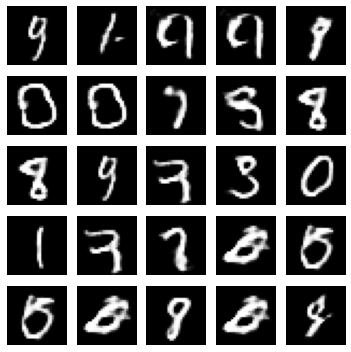

Epoch [90 / 200], Generator Loss : 2.281792163848877, Discriminator Loss : 0.9274753332138062
Discriminator's fake image acc : 20.49, Discriminator's real image acc : 92.17
Epoch [91 / 200], Generator Loss : 2.207840919494629, Discriminator Loss : 0.897547721862793
Discriminator's fake image acc : 20.13, Discriminator's real image acc : 92.11
Epoch [92 / 200], Generator Loss : 2.4091269969940186, Discriminator Loss : 0.9425095319747925
Discriminator's fake image acc : 20.68, Discriminator's real image acc : 92.03
Epoch [93 / 200], Generator Loss : 2.273965835571289, Discriminator Loss : 0.8743671774864197
Discriminator's fake image acc : 20.41, Discriminator's real image acc : 91.84
Epoch [94 / 200], Generator Loss : 2.208895444869995, Discriminator Loss : 0.9150586724281311
Discriminator's fake image acc : 20.36, Discriminator's real image acc : 92.0
Epoch [95 / 200], Generator Loss : 2.3502354621887207, Discriminator Loss : 0.8840742707252502
Discriminator's fake image acc : 20.6, Di

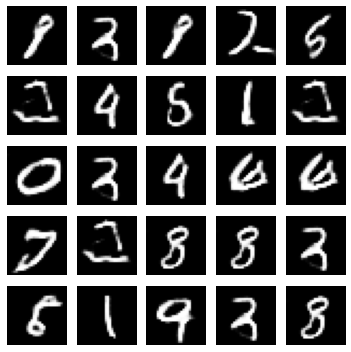

Epoch [100 / 200], Generator Loss : 2.0967297554016113, Discriminator Loss : 0.8754024505615234
Discriminator's fake image acc : 20.83, Discriminator's real image acc : 91.95
Epoch [101 / 200], Generator Loss : 2.2848241329193115, Discriminator Loss : 0.8838644623756409
Discriminator's fake image acc : 20.86, Discriminator's real image acc : 92.14
Epoch [102 / 200], Generator Loss : 2.4230782985687256, Discriminator Loss : 0.8610212206840515
Discriminator's fake image acc : 20.79, Discriminator's real image acc : 92.11
Epoch [103 / 200], Generator Loss : 2.2391576766967773, Discriminator Loss : 0.8913986086845398
Discriminator's fake image acc : 20.96, Discriminator's real image acc : 91.9
Epoch [104 / 200], Generator Loss : 2.3096508979797363, Discriminator Loss : 0.9752395153045654
Discriminator's fake image acc : 20.81, Discriminator's real image acc : 92.01
Epoch [105 / 200], Generator Loss : 2.192110300064087, Discriminator Loss : 0.9307434558868408
Discriminator's fake image acc 

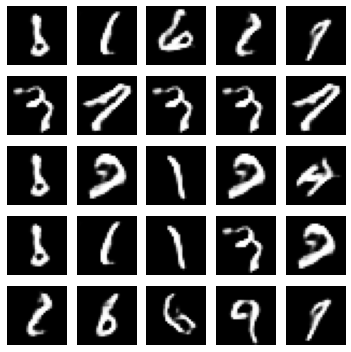

Epoch [110 / 200], Generator Loss : 2.1376562118530273, Discriminator Loss : 0.897555947303772
Discriminator's fake image acc : 20.72, Discriminator's real image acc : 91.91
Epoch [111 / 200], Generator Loss : 2.238287925720215, Discriminator Loss : 1.0175020694732666
Discriminator's fake image acc : 20.77, Discriminator's real image acc : 91.9
Epoch [112 / 200], Generator Loss : 2.4036264419555664, Discriminator Loss : 0.9610235691070557
Discriminator's fake image acc : 20.94, Discriminator's real image acc : 91.97
Epoch [113 / 200], Generator Loss : 2.2021048069000244, Discriminator Loss : 0.9945513606071472
Discriminator's fake image acc : 20.57, Discriminator's real image acc : 92.11
Epoch [114 / 200], Generator Loss : 2.399754047393799, Discriminator Loss : 0.9030234813690186
Discriminator's fake image acc : 20.79, Discriminator's real image acc : 91.82
Epoch [115 / 200], Generator Loss : 2.327146291732788, Discriminator Loss : 0.923219621181488
Discriminator's fake image acc : 20

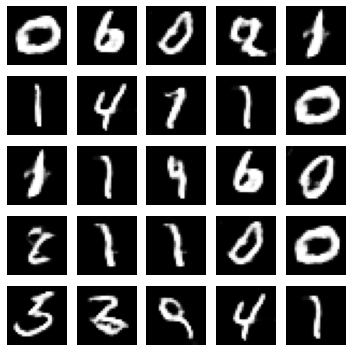

Epoch [120 / 200], Generator Loss : 2.3666577339172363, Discriminator Loss : 0.9863809943199158
Discriminator's fake image acc : 20.62, Discriminator's real image acc : 92.03
Epoch [121 / 200], Generator Loss : 2.4315271377563477, Discriminator Loss : 0.8636966943740845
Discriminator's fake image acc : 20.99, Discriminator's real image acc : 91.83
Epoch [122 / 200], Generator Loss : 2.3376829624176025, Discriminator Loss : 0.8459339141845703
Discriminator's fake image acc : 20.93, Discriminator's real image acc : 91.92
Epoch [123 / 200], Generator Loss : 2.3407034873962402, Discriminator Loss : 0.9365521669387817
Discriminator's fake image acc : 20.91, Discriminator's real image acc : 91.93
Epoch [124 / 200], Generator Loss : 2.378739833831787, Discriminator Loss : 0.9176537990570068
Discriminator's fake image acc : 21.36, Discriminator's real image acc : 92.0
Epoch [125 / 200], Generator Loss : 2.4149084091186523, Discriminator Loss : 0.8347011804580688
Discriminator's fake image acc 

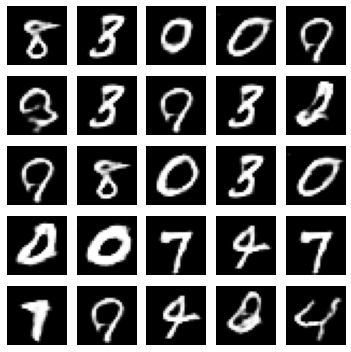

Epoch [130 / 200], Generator Loss : 2.462812662124634, Discriminator Loss : 0.8026227951049805
Discriminator's fake image acc : 21.16, Discriminator's real image acc : 91.78
Epoch [131 / 200], Generator Loss : 2.3285529613494873, Discriminator Loss : 0.8932486176490784
Discriminator's fake image acc : 21.4, Discriminator's real image acc : 91.8
Epoch [132 / 200], Generator Loss : 2.4797732830047607, Discriminator Loss : 0.9445401430130005
Discriminator's fake image acc : 21.4, Discriminator's real image acc : 91.66
Epoch [133 / 200], Generator Loss : 2.1864254474639893, Discriminator Loss : 0.8647133708000183
Discriminator's fake image acc : 21.32, Discriminator's real image acc : 91.82
Epoch [134 / 200], Generator Loss : 2.353006601333618, Discriminator Loss : 0.8948043584823608
Discriminator's fake image acc : 21.29, Discriminator's real image acc : 91.79
Epoch [135 / 200], Generator Loss : 2.400404214859009, Discriminator Loss : 0.9369521141052246
Discriminator's fake image acc : 21

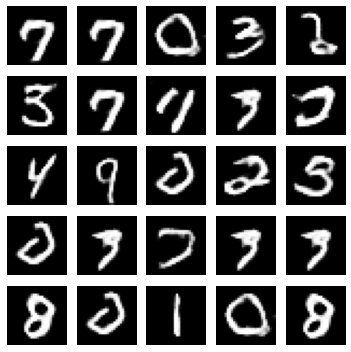

Epoch [140 / 200], Generator Loss : 2.243324041366577, Discriminator Loss : 0.8192601203918457
Discriminator's fake image acc : 21.5, Discriminator's real image acc : 91.75
Epoch [141 / 200], Generator Loss : 2.191598892211914, Discriminator Loss : 0.8548750281333923
Discriminator's fake image acc : 21.64, Discriminator's real image acc : 91.71
Epoch [142 / 200], Generator Loss : 2.368821144104004, Discriminator Loss : 0.9047974348068237
Discriminator's fake image acc : 21.09, Discriminator's real image acc : 91.66
Epoch [143 / 200], Generator Loss : 2.3002102375030518, Discriminator Loss : 0.9497514963150024
Discriminator's fake image acc : 21.64, Discriminator's real image acc : 91.74
Epoch [144 / 200], Generator Loss : 2.388728141784668, Discriminator Loss : 0.8914443254470825
Discriminator's fake image acc : 21.62, Discriminator's real image acc : 91.67
Epoch [145 / 200], Generator Loss : 2.4424359798431396, Discriminator Loss : 0.9170033931732178
Discriminator's fake image acc : 2

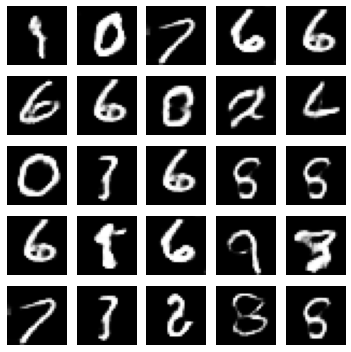

Epoch [150 / 200], Generator Loss : 2.377716064453125, Discriminator Loss : 0.8948251008987427
Discriminator's fake image acc : 21.63, Discriminator's real image acc : 91.72
Epoch [151 / 200], Generator Loss : 2.122000217437744, Discriminator Loss : 0.9406924247741699
Discriminator's fake image acc : 21.28, Discriminator's real image acc : 91.41
Epoch [152 / 200], Generator Loss : 2.2830536365509033, Discriminator Loss : 0.9362738132476807
Discriminator's fake image acc : 21.04, Discriminator's real image acc : 91.5
Epoch [153 / 200], Generator Loss : 2.31536865234375, Discriminator Loss : 0.8532406687736511
Discriminator's fake image acc : 21.54, Discriminator's real image acc : 91.62
Epoch [154 / 200], Generator Loss : 2.440223217010498, Discriminator Loss : 0.8708807826042175
Discriminator's fake image acc : 21.39, Discriminator's real image acc : 91.76
Epoch [155 / 200], Generator Loss : 2.3954031467437744, Discriminator Loss : 0.8574005365371704
Discriminator's fake image acc : 21

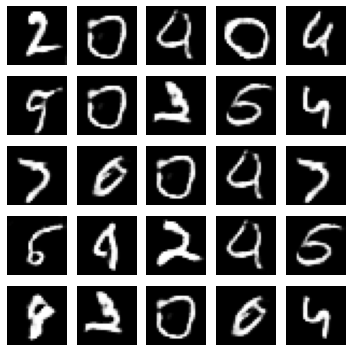

Epoch [160 / 200], Generator Loss : 2.4352598190307617, Discriminator Loss : 0.8948902487754822
Discriminator's fake image acc : 21.46, Discriminator's real image acc : 91.64
Epoch [161 / 200], Generator Loss : 2.259397029876709, Discriminator Loss : 0.9154734015464783
Discriminator's fake image acc : 21.36, Discriminator's real image acc : 91.59
Epoch [162 / 200], Generator Loss : 2.364652156829834, Discriminator Loss : 0.7961974143981934
Discriminator's fake image acc : 21.67, Discriminator's real image acc : 91.43
Epoch [163 / 200], Generator Loss : 2.473308801651001, Discriminator Loss : 0.8310209512710571
Discriminator's fake image acc : 21.67, Discriminator's real image acc : 91.52
Epoch [164 / 200], Generator Loss : 2.5208420753479004, Discriminator Loss : 0.8507550954818726
Discriminator's fake image acc : 21.66, Discriminator's real image acc : 91.61
Epoch [165 / 200], Generator Loss : 2.3367791175842285, Discriminator Loss : 0.9328603148460388
Discriminator's fake image acc :

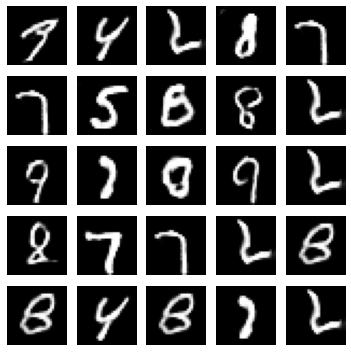

Epoch [170 / 200], Generator Loss : 2.385978937149048, Discriminator Loss : 0.9180214405059814
Discriminator's fake image acc : 21.42, Discriminator's real image acc : 91.55
Epoch [171 / 200], Generator Loss : 2.408527374267578, Discriminator Loss : 0.9183846712112427
Discriminator's fake image acc : 21.5, Discriminator's real image acc : 91.47
Epoch [172 / 200], Generator Loss : 2.198179244995117, Discriminator Loss : 0.9691693782806396
Discriminator's fake image acc : 21.81, Discriminator's real image acc : 91.69
Epoch [173 / 200], Generator Loss : 2.2668304443359375, Discriminator Loss : 0.9511641263961792
Discriminator's fake image acc : 21.57, Discriminator's real image acc : 91.34
Epoch [174 / 200], Generator Loss : 2.5411171913146973, Discriminator Loss : 0.8878045082092285
Discriminator's fake image acc : 21.59, Discriminator's real image acc : 91.58
Epoch [175 / 200], Generator Loss : 2.074873447418213, Discriminator Loss : 0.856018602848053
Discriminator's fake image acc : 21

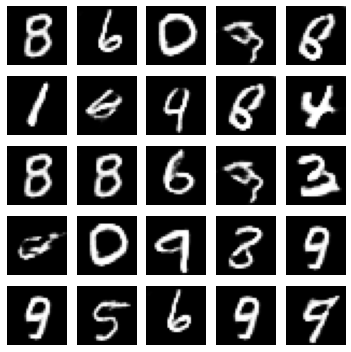

Epoch [180 / 200], Generator Loss : 2.449730634689331, Discriminator Loss : 0.8895894289016724
Discriminator's fake image acc : 21.97, Discriminator's real image acc : 91.5
Epoch [181 / 200], Generator Loss : 2.435924530029297, Discriminator Loss : 0.9141426682472229
Discriminator's fake image acc : 21.84, Discriminator's real image acc : 91.42
Epoch [182 / 200], Generator Loss : 2.560638904571533, Discriminator Loss : 0.8834724426269531
Discriminator's fake image acc : 21.86, Discriminator's real image acc : 91.57
Epoch [183 / 200], Generator Loss : 2.3474032878875732, Discriminator Loss : 0.9139333963394165
Discriminator's fake image acc : 21.59, Discriminator's real image acc : 91.62
Epoch [184 / 200], Generator Loss : 2.237534284591675, Discriminator Loss : 0.892396092414856
Discriminator's fake image acc : 21.35, Discriminator's real image acc : 91.53
Epoch [185 / 200], Generator Loss : 2.488213062286377, Discriminator Loss : 0.8794852495193481
Discriminator's fake image acc : 21.

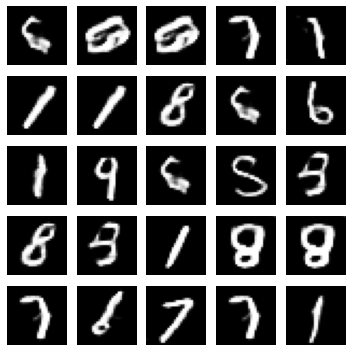

Epoch [190 / 200], Generator Loss : 2.2139244079589844, Discriminator Loss : 0.8600578308105469
Discriminator's fake image acc : 21.82, Discriminator's real image acc : 91.39
Epoch [191 / 200], Generator Loss : 2.3759379386901855, Discriminator Loss : 0.8483607172966003
Discriminator's fake image acc : 22.27, Discriminator's real image acc : 91.44
Epoch [192 / 200], Generator Loss : 2.307603359222412, Discriminator Loss : 0.8439186811447144
Discriminator's fake image acc : 22.19, Discriminator's real image acc : 91.23
Epoch [193 / 200], Generator Loss : 2.381521224975586, Discriminator Loss : 0.9096307158470154
Discriminator's fake image acc : 22.03, Discriminator's real image acc : 91.4
Epoch [194 / 200], Generator Loss : 2.28194522857666, Discriminator Loss : 0.9520089030265808
Discriminator's fake image acc : 22.43, Discriminator's real image acc : 91.37
Epoch [195 / 200], Generator Loss : 2.4712483882904053, Discriminator Loss : 0.9106380939483643
Discriminator's fake image acc : 2

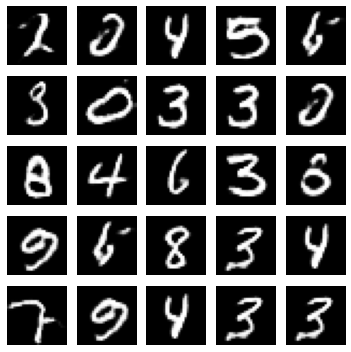

Epoch [200 / 200], Generator Loss : 2.3446502685546875, Discriminator Loss : 0.8701033592224121
Discriminator's fake image acc : 22.32, Discriminator's real image acc : 91.29


In [54]:
for epoch in range(num_epochs):
  fake_image_correct = 0
  real_image_correct = 0
  total = 0
  for imgs, labels in dataloader:
    real_imgs = imgs.to(device)
    labels = labels.to(device)
    
    # Generate fake images
    c = torch.LongTensor(np.random.choice(num_classes, size = (imgs.size(0)))).to(device)
    z = torch.normal(mean = 0, std = 1, size = (imgs.size(0), latent_dim)).to(device)
    fake_imgs = generator(z, c)
    
    # Adversarial ground truths
    real = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)
    fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad = False)
    fake_aux_gt = Variable(c, requires_grad = False)    
    
    # Train the Generator
    optimizer_G.zero_grad()
    loss_G = (adversarial_loss(discriminator(fake_imgs)[0], real) + classification_loss(discriminator(fake_imgs)[1], labels)) / 2
    
    loss_G.backward()
    optimizer_G.step()

    # Train the Discriminator
    optimizer_D.zero_grad()

    real_imgs_loss = (adversarial_loss(discriminator(real_imgs)[0], real) + classification_loss(discriminator(real_imgs)[1], labels)) / 2
    fake_imgs_loss = (adversarial_loss(discriminator(fake_imgs.detach())[0], fake) + classification_loss(discriminator(fake_imgs.detach())[1], fake_aux_gt)) / 2

    loss_D = (real_imgs_loss + fake_imgs_loss) / 2
    
    loss_D.backward()
    optimizer_D.step()
    

    # Discriminator's accuracy
    _, discriminator_fake_class = torch.max(discriminator(fake_imgs)[1], dim = -1)
    _, discriminator_real_class = torch.max(discriminator(real_imgs)[1], dim = -1)
    fake_image_correct += (c == discriminator_fake_class).sum().item()
    real_image_correct += (labels == discriminator_real_class).sum().item()
    total += imgs.size(0)

  if (epoch + 1) % 10 == 0:
    plot_fake_imgs(fake_imgs[:25].detach().cpu().numpy())
    torch.save(generator.state_dict(), "SGAN_gen.ckpt")
    torch.save(discriminator.state_dict(), "SGAN_dis.ckpt")
  print(f"Epoch [{epoch + 1} / {num_epochs}], Generator Loss : {loss_G.item()}, Discriminator Loss : {loss_D.item()}")
  print(f"Discriminator's fake image acc : {round(100 * fake_image_correct / total, 2)}, Discriminator's real image acc : {round(100 * real_image_correct / total, 2)}")
